In [1]:
%pip install missingno > /dev/null
!pip install category_encoders > /dev/null
!pip install rfpimp > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn import base
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor, MLPClassifier
from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,confusion_matrix
from IPython.display import Image
import warnings
import pandas as pd
import numpy as np
import collections as c
import sklearn

from sklearn.preprocessing import MultiLabelBinarizer
import category_encoders as ce
from sklearn import preprocessing

# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_selection import SelectFromModel

# example of auto-sklearn for a classification dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from autosklearn.classification import AutoSklearnClassifier
import autosklearn

import copy
import time
import pickle
import itertools
from typing import List
import datetime

# pip install nb_black
%load_ext nb_black

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 1000)  # or None
pd.set_option("display.max_rows", 1000)  # or None
pd.set_option("display.max_colwidth", -1)  # or -1


/home/iceking/Desktop/TUM Lecture Docs/3. Business Analytics and Machine Learning (IN2028)/Analytics Cup/Project Files/venv/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/home/iceking/Desktop/TUM Lecture Docs/3. Business Analytics and Machine Learning (IN2028)/Analytics Cup/Project Files/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


<IPython.core.display.Javascript object>

## Helper Functions

In [3]:
def type_separator(df: pd.DataFrame, print_results=True):
    set_separator = {}
    for col in df.columns:

        unique_vals = set(df[col].dropna().unique())
        if type(df[col].dtype) == pd.CategoricalDtype:
            a = "cat"
        elif unique_vals == {0, 1} or unique_vals == {0.0, 1.0}:
            a = "binary"
        elif len(unique_vals) < 2 or (
            df[col].dtype == np.dtype("object") and len(unique_vals) > 500
        ):
            raise ValueError(
                f"[ERROR] Something wrong with column:{col} cannot be this, case check conversions!"
            )
        else:
            a = {
                np.dtype("object"): "cat",
                np.dtype("int"): "numerical",
                np.dtype("int32"): "integer",
                np.dtype("int64"): "integer",
                np.dtype("uint8"): "integer",
                np.dtype("float"): "continuous",
            }[df[col].dtype]

        if a in list(set_separator.keys()):
            set_separator[a].append(col)
        else:
            set_separator[a] = [col]

    if print_results:
        for key, val in set_separator.items():
            print("type:", key, "columns:")
            for col in sorted(val):
                print(">", col)
            print("-" * 32)
        return None
    return set_separator

<IPython.core.display.Javascript object>

In [4]:
def get_null_columns(df: pd.DataFrame) -> List:
    return [col for col in df.columns if np.any(df[col].isna())]


def get_non_null_columns(df: pd.DataFrame) -> List:
    return [col for col in df.columns if not np.any(df[col].isna())]


def get_inf_columns(df: pd.DataFrame) -> List:
    return [col for col in df.columns if np.any(df[col] == np.inf)]


def print_nan_and_inf_columns(df: pd.DataFrame):
    print("NaN and Infinity Columns and Counts:")
    for col in sorted(get_null_columns(df)):
        print("> [NaN     ]", col, "Null Count:", np.sum(df[col].isna()))
    for col in sorted(get_inf_columns(df)):
        print("> [INFINITY]", col, "Inf Count:", np.sum(df[col] == np.inf))


def get_labeled_set(df: pd.DataFrame, target_col: str = "OFFER_STATUS"):
    return df[~np.isnan(df[target_col])]


def get_unlabeled_set(df: pd.DataFrame, target_col: str = "OFFER_STATUS"):
    return df[np.isnan(df[target_col])]


def MissingUniqueStatistics(df, show_unique_values=False):

    total_entry_list = []
    total_missing_value_list = []
    missing_value_ratio_list = []
    data_type_list = []
    unique_values_list = []
    number_of_unique_values_list = []
    variable_name_list = []

    for col in df.columns:

        variable_name_list.append(col)
        missing_value_ratio = round((df[col].isna().sum() / len(df[col])), 4)
        total_entry_list.append(df[col].shape[0] - df[col].isna().sum())
        total_missing_value_list.append(df[col].isna().sum())
        missing_value_ratio_list.append(missing_value_ratio)
        data_type_list.append(df[col].dtype)
        unique_values_list.append(list(df[col].unique()))
        number_of_unique_values_list.append(len(df[col].unique()))

    data_info_df = pd.DataFrame(
        {
            "Variable": variable_name_list,
            "#_Total_Entry": total_entry_list,
            "#_Missing_Value": total_missing_value_list,
            "%_Missing_Value": missing_value_ratio_list,
            "Data_Type": data_type_list,
            "Unique_Values": unique_values_list,
            "#_Uniques_Values": number_of_unique_values_list,
        }
    )
    if not show_unique_values:
        data_info_df = data_info_df.drop("Unique_Values", axis=1)

    return data_info_df.sort_values(by="#_Missing_Value", ascending=False).set_index(
        "Variable"
    )


def histogram(df, feature):  # Histogram of the target categories
    %matplotlib inline
    ncount = len(df)
    ax = sns.countplot(x=feature, data=df, palette="hls")
    sns.set(font_scale=1)
    ax.set_xlabel("Target Segments")
    plt.xticks(rotation=90)
    ax.set_ylabel("Number of Observations")
    fig = plt.gcf()
    fig.set_size_inches(12, 5)
    # Make twin axis
    ax2 = ax.twinx()
    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()
    # Also switch the labels over
    ax.yaxis.set_label_position("right")
    ax2.yaxis.set_label_position("left")
    ax2.set_ylabel("Frequency [%]")
    for p in ax.patches:
        x = p.get_bbox().get_points()[:, 0]
        y = p.get_bbox().get_points()[1, 1]
        ax.annotate(
            "{:.2f}%".format(100.0 * y / ncount),
            (x.mean(), y),
            ha="center",
            va="bottom",
        )  # set the alignment of the text
    # Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(ticker.LinearLocator(11))
    # Fix the frequency range to 0-100
    ax2.set_ylim(0, 100)
    ax.set_ylim(0, ncount)
    # And use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))
    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)
    plt.title("Histogram of Binary Target Categories", fontsize=20, y=1.08)
    plt.show()
    plt.savefig("target_histogram.png")
    del ncount, x, y

    # USAGE: histogram(data, "CLASS")

<IPython.core.display.Javascript object>

## Code

In [77]:
# Read Data
df = pd.read_csv("interim_data/df_completed_1_2_3_with_mv_new.csv")
# df = pd.read_csv("interim_data/df_completed_1_2_3.csv")

id_columns = ["CUSTOMER", "TEST_SET_ID", "IDX_CUSTOMER"]
#unnecessary_reduced_cols = [
#    "OFFER_TYPE_REDUCED_1",
#    "OFFER_TYPE_REDUCED_2",
#    "SALES_OFFICE_REDUCED",
#]

#to_be_dropped_cols = id_columns + unnecessary_reduced_cols
#df = df.drop(to_be_dropped_cols, axis=1)
df = df.drop(id_columns, axis=1)
# new columns
df["ADDITIONAL_COST"] = df["OFFER_PRICE"] - df["MATERIAL_COST"] - df["SERVICE_COST"]
df["TOTAL_COST"] = df["MATERIAL_COST"] + df["SERVICE_COST"]
df["TOTAL_COST_LOG"] = df["MATERIAL_COST"] + df["SERVICE_COST"]
df["TOTAL_COST_RATIO"] = df["MATERIAL_COST"] / df["SERVICE_COST"]
df["TOTAL_COST_RATIO"] = df["MATERIAL_COST"] / df["TOTAL_COST"]
#df["TOTAL_COST_RATIO_LOG"] = np.log(df["TOTAL_COST_RATIO"] + 1)


<IPython.core.display.Javascript object>

In [78]:
needed = False
boruta_feed = True

if boruta_feed:
    print("[INFO] Picking cols selected by Boruta..")
    by_boruta_selected_cols = [
        ################################ Target Column - START
        "OFFER_STATUS",
        ################################ Target Column  - END
        "ADDITIONAL_COST",  # , # 1, # True',
        "BUSINESS_TYPE",  # , # 1, # True',
        "OFFER_TYPE",  # , # 1, # True',
        "OFFER_TYPE_REDUCED_1",  # , # 1, # True',
        "OFFER_TYPE_REDUCED_2",  # , # 1, # True',
        "REV_AVG",  # , # 1, # True',
        "REV_CURRENT_YEAR.1",  # , # 1, # True',
        "REV_CURRENT_YEAR_LOG.1",  # , # 1, # True',
        "REV_CURRENT_YEAR_LOG.2",  # , # 1, # True',
        "REV_RATE",  # , # 1, # True',
        "SALES_LOCATION",  # , # 1, # True',
        "SALES_OFFICE",  # , # 1, # True',
        "SALES_OFFICE_REDUCED",  # , # 1, # True',
        "SERVICE_COST",  # , # 1, # True',
        "SERVICE_COST_LOG",  # , # 1, # True',
        "SO_CREATED_DATE_INTEGER",  # , # 1, # True',
        # "SO_CREATED_DATE_SCALED",  # , # 1, # True',
        "TOTAL_COST_RATIO",  # , # 1, # True',
        "OFFER_PRICE_LOG",  # , # 2, # False',
        "OFFER_PRICE",  # , # 3, # False',
        "TECH_REDUCED_1",  # , # 4, # False',
        # "REV_CURRENT_YEAR.2",  # , # 5, # False',
        # "TOTAL_COST",  # , # 5, # False',
        "TECH",  # , # 7, # False',
        "TOTAL_COST_LOG",  # , # 7, # False',
        "PRICE_LIST",  # , # 9, # False',
        "SERVICE_LIST_PRICE",  # , # 9, # False',
        "SERVICE_LIST_PRICE_LOG",  # , # 11, # False',
        # "MATERIAL_COST_LOG",  # , # 12, # False',
        "MATERIAL_COST",  # , # 13, # False',
        "CURRENCY",  # , # 14, # False',
        "SINCE_CREATION_YEAR",  # , # 15, # False',
        # "CREATION_YEAR",  # , # 16, # False',
        # "CREATION_YEAR_LOG",  # , # 16, # False',
        # "SINCE_CREATION_YEAR_LOG",  # , # 18, # False',
        #########################################################33
        # 'TECH_REDUCED_2_IS_F', # , # 19, # False',
        # 'OWNERSHIP_NA_AS_NO_INFO', # , # 21, # False',
        # 'TOTAL_COSTS_PRODUCT', # , # 21, # False',
        # 'TOTAL_COSTS_PRODUCT_LOG', # , # 21, # False',
        # 'OWNERSHIP_NA_AS_NO_INFO_REDUCED', # , # 23, # False',
        # 'OWNERSHIP', # , # 24, # False',
        # 'OWNERSHIP_REDUCED', # , # 24, # False',
        # 'OWNERSHIP_NO_INFO_AS_NA_REDUCED', # , # 26, # False',
        # 'OWNERSHIP_NO_INFO_AS_NA', # , # 27, # False',
        # 'IS_COUNTRY_CODE_CH', # , # 28, # False',
        # 'HAS_END_CUSTOMER', # , # 29, # False',
        # 'IS_NA_REV_RATE', # , # 30, # False',
        # 'IS_NA_REV_AVG', # , # 31, # False',
        # 'HAS_COSTS_PRODUCT_D', # , # 32, # False',
        # 'HAS_COSTS_PRODUCT_B', # , # 33, # False',
        # 'IS_NA_REV_CURRENT_YEAR', # , # 33, # False',
        # 'IS_NA_CURRENCY', # , # 35, # False',
        # 'IS_NA_OWNERSHIP_NO_INFO_AS_NA', # , # 35, # False',
        # 'HAS_ISIC', # , # 37, # False',
        # 'HAS_COSTS_PRODUCT_A', # , # 38, # False',
        # 'HAS_COSTS_PRODUCT_E', # , # 39, # False',
        # 'HAS_COSTS_PRODUCT_C', # , # 40, # False',
        # 'IS_NA_SALES_OFFICE', # , # 41, # False',
        # 'IS_NA_SALES_LOCATION', # , # 42, # False'
    ]
    df = df[by_boruta_selected_cols]
if needed:
    selected_cols = [
        ################################ Target Column
        "OFFER_STATUS",
        ################################ Numerical: Original Columns
        # [abs(Corr)=0.96 with: "SINCE_CREATION_YEAR_LOG"] "SINCE_CREATION_YEAR",
        # [abs(Corr)=1.00 with: "SINCE_CREATION_YEAR"] "CREATION_YEAR",
        # [abs(Corr)=0.99 with: "SERVICE_LIST_PRICE"] "MATERIAL_COST",
        # [abs(Corr)=0.96 with: "TOTAL_COST"] "OFFER_PRICE",
        # [abs(Corr)=0.99 with: "REV_AVG"] #"REV_CURRENT_YEAR.1",
        # [abs(Corr)=0.99 with: "REV_AVG"] #"REV_CURRENT_YEAR.2",
        "SERVICE_COST",
        "SERVICE_LIST_PRICE",
        # [abs(Corr)=1.00 with: "SO_CREATED_DATE_SCALED"] "SO_CREATED_DATE_INTEGER",
        ################################ Categorical: Original Columns
        "BUSINESS_TYPE",
        "CURRENCY",
        "OFFER_TYPE",
        "OWNERSHIP",
        "PRICE_LIST",
        "SALES_LOCATION",
        "SALES_OFFICE",
        "TECH",
        ################################ Binary: Original Columns
        "HAS_COSTS_PRODUCT_A",
        "HAS_COSTS_PRODUCT_B",
        "HAS_COSTS_PRODUCT_C",
        "HAS_COSTS_PRODUCT_D",
        "HAS_COSTS_PRODUCT_E",
        "HAS_END_CUSTOMER",
        "HAS_ISIC",
        "IS_COUNTRY_CODE_CH",
        ################################ Numerical: Derived Columns
        "SO_CREATED_DATE_SCALED",
        "TOTAL_COSTS_PRODUCT",
        "ADDITIONAL_COST",
        "TOTAL_COST",
        "TOTAL_COST_RATIO",
        "REV_AVG",
        "REV_RATE",
        ################################ Binary: IS NA Columns
        # [abs(Corr)=1.00 with: "IS_NA_REV_CURRENT_YEAR"] "IS_NA_CURRENCY",
        # [abs(Corr)=0.99 with: "IS_NA_REV_CURRENT_YEAR"] "IS_NA_OWNERSHIP_NO_INFO_AS_NA",
        # [abs(Corr)=0.99 with: "TOTAL_COST"] "IS_NA_REV_AVG",
        "IS_NA_REV_CURRENT_YEAR",
        "IS_NA_REV_RATE",
        # [abs(Corr)=0.99 with: "IS_NA_SALES_OFFICE"] "IS_NA_SALES_LOCATION",
        "IS_NA_SALES_OFFICE",
        ################################ Categorical: Reduced Columns
        "OFFER_TYPE_REDUCED_1",
        "OFFER_TYPE_REDUCED_2",
        "OWNERSHIP_NA_AS_NO_INFO_REDUCED",
        "OWNERSHIP_NO_INFO_AS_NA_REDUCED",
        "OWNERSHIP_REDUCED",
        "SALES_OFFICE_REDUCED",
        "TECH_REDUCED_1",
        "TECH_REDUCED_2_IS_F",
        "OWNERSHIP_NA_AS_NO_INFO",
        "OWNERSHIP_NO_INFO_AS_NA",
        ################################ Numerical: Log Transformed Columns
        # [abs(Corr)=1.00 with: "SINCE_CREATION_YEAR"] "CREATION_YEAR_LOG",
        "MATERIAL_COST_LOG",
        "OFFER_PRICE_LOG",
        "REV_CURRENT_YEAR_LOG.1",
        "REV_CURRENT_YEAR_LOG.2",
        "SERVICE_COST_LOG",
        # [abs(Corr)=1.00 with: ""MATERIAL_COST_LOG""] "SERVICE_LIST_PRICE_LOG",
        "SINCE_CREATION_YEAR_LOG",
        "TOTAL_COSTS_PRODUCT_LOG",
        # [abs(Corr)=1 with: "TOTAL_COST"] "TOTAL_COST_LOG",
    ]
    df = df[selected_cols]

[INFO] Picking cols selected by Boruta..


<IPython.core.display.Javascript object>

In [79]:
df_info = MissingUniqueStatistics(df)
df_info

,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,#_Uniques_Values
Variable,,,,,
REV_RATE,19441,6710,0.2566,float64,5755
REV_CURRENT_YEAR_LOG.1,23204,2947,0.1127,float64,6421
REV_CURRENT_YEAR_LOG.2,23215,2936,0.1123,float64,6200
SINCE_CREATION_YEAR,23266,2885,0.1103,float64,20
REV_CURRENT_YEAR.1,23266,2885,0.1103,float64,6450
CURRENCY,23266,2885,0.1103,object,5
REV_AVG,23266,2885,0.1103,float64,6953
OFFER_STATUS,23575,2576,0.0985,float64,3
SALES_OFFICE,26113,38,0.0015,object,39


<IPython.core.display.Javascript object>

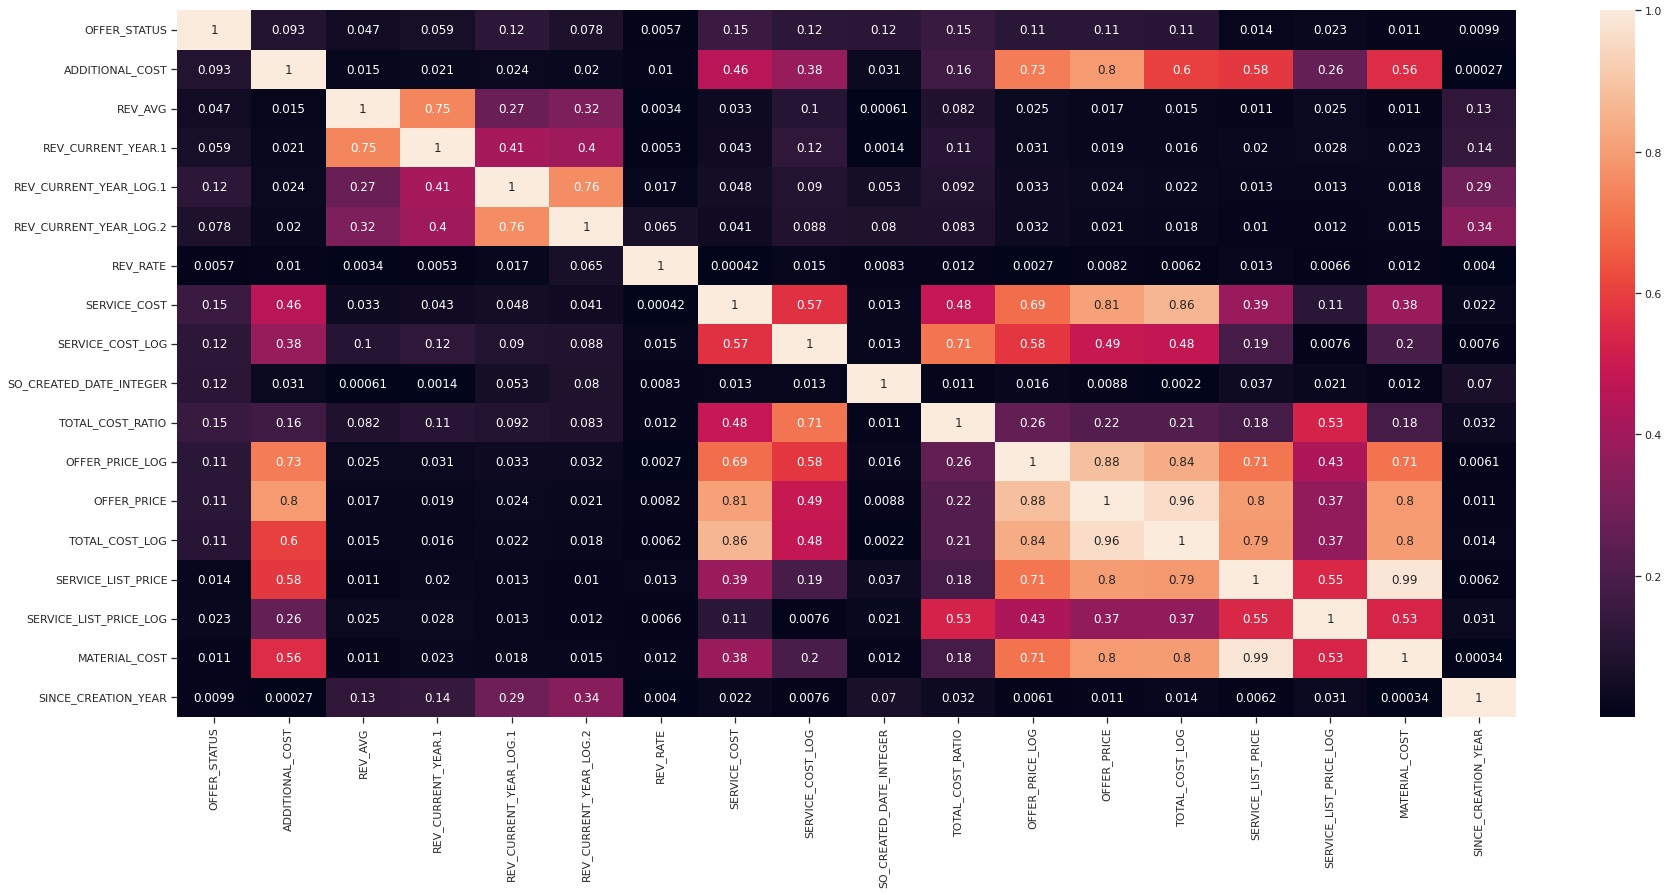

<IPython.core.display.Javascript object>

In [80]:
f, ax = plt.subplots(figsize=(30, 13))
sns.heatmap(
    abs(df.corr()),
    annot=True,
)
plt.show()

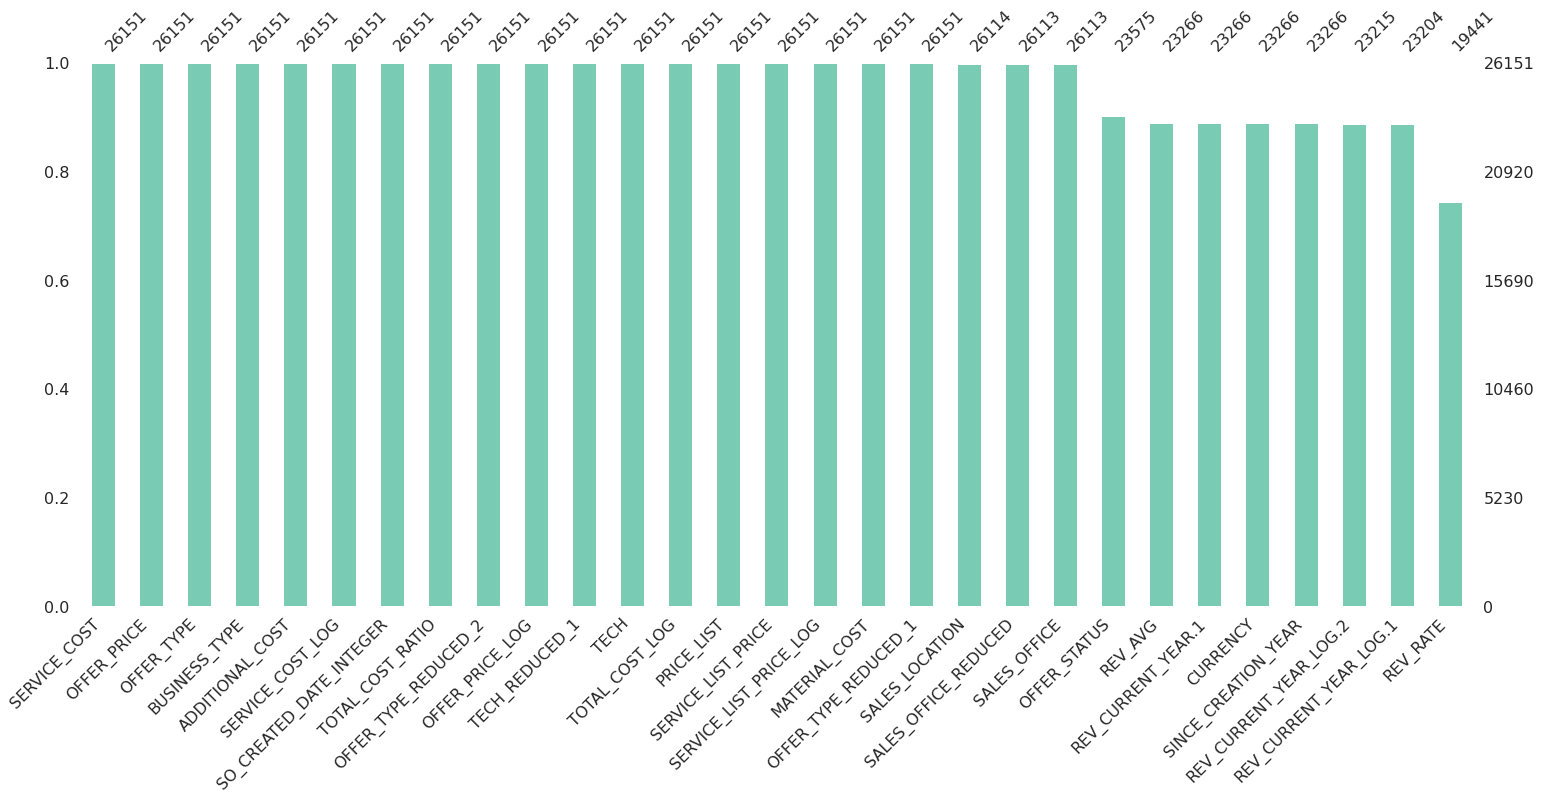

<IPython.core.display.Javascript object>

In [81]:
msno.bar(df, color="#79ccb3", sort="descending")
plt.show()

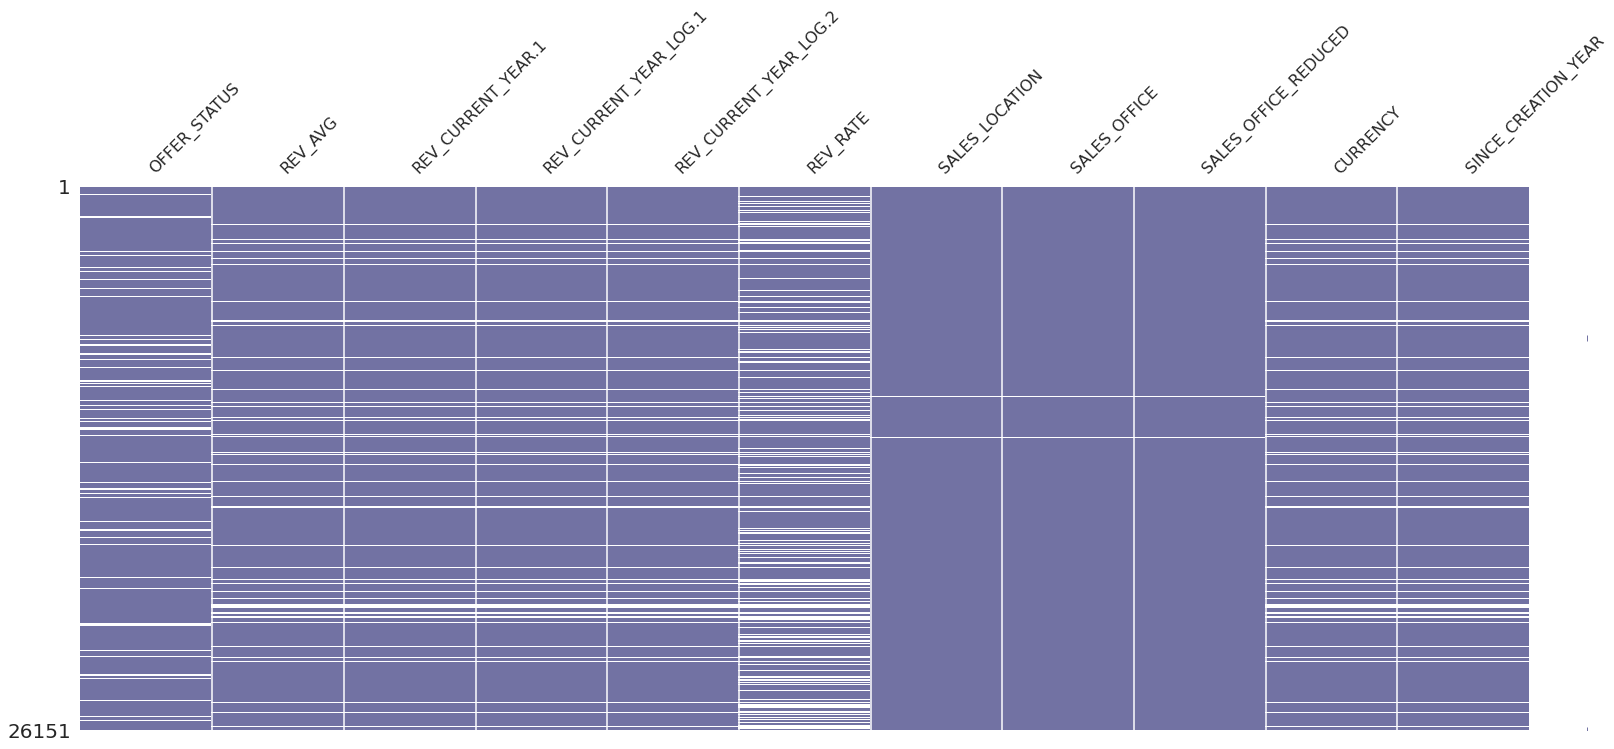

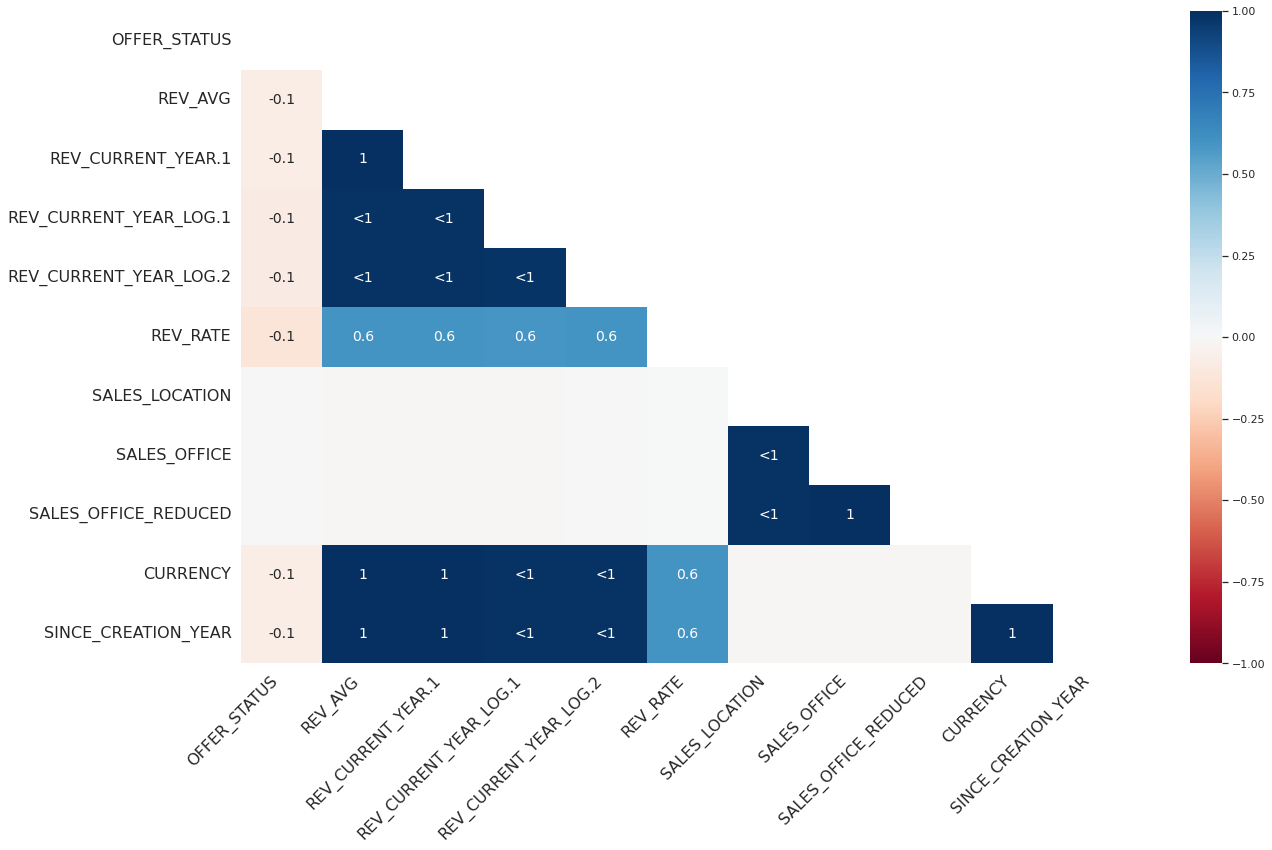

<IPython.core.display.Javascript object>

In [82]:
msno.matrix(
    df[get_null_columns(df)],
    color=(0.45, 0.45, 0.64),
    figsize=(27, 10),
    width_ratios=(10, 0),
)
plt.show()

# msno.dendrogram(df[get_null_columns(df)])

msno.heatmap(df[get_null_columns(df)])
plt.show()

In [83]:
col_to_type = [
    ######################### Nominal
    ("BUSINESS_TYPE", "Nominal"),
    ("CURRENCY", "Nominal"),
    ("HAS_COSTS_PRODUCT_A", "Nominal"),
    ("HAS_COSTS_PRODUCT_B", "Nominal"),
    ("HAS_COSTS_PRODUCT_C", "Nominal"),
    ("HAS_COSTS_PRODUCT_D", "Nominal"),
    ("HAS_COSTS_PRODUCT_E", "Nominal"),
    ("HAS_END_CUSTOMER", "Nominal"),
    ("HAS_ISIC", "Nominal"),
    ("IS_COUNTRY_CODE_CH", "Nominal"),
    ("IS_NA_CURRENCY", "Nominal"),
    ("IS_NA_OWNERSHIP_NO_INFO_AS_NA", "Nominal"),
    ("IS_NA_REV_CURRENT_YEAR", "Nominal"),
    ("IS_NA_REV_AVG", "Nominal"),
    ("IS_NA_REV_RATE", "Nominal"),
    ("IS_NA_SALES_OFFICE", "Nominal"),
    ("IS_NA_SALES_LOCATION", "Nominal"),
    ("OFFER_STATUS", "Nominal"),
    ("OFFER_TYPE", "Nominal"),
    ("OFFER_TYPE_REDUCED_1", "Nominal"),
    ("OFFER_TYPE_REDUCED_2", "Nominal"),
    ("OWNERSHIP", "Nominal"),
    ("OWNERSHIP_NA_AS_NO_INFO", "Nominal"),
    ("OWNERSHIP_NA_AS_NO_INFO_REDUCED", "Nominal"),
    ("OWNERSHIP_NO_INFO_AS_NA", "Nominal"),
    ("OWNERSHIP_NO_INFO_AS_NA_REDUCED", "Nominal"),
    ("OWNERSHIP_REDUCED", "Nominal"),
    ("PRICE_LIST", "Nominal"),
    ("SALES_LOCATION", "Nominal"),
    ("SALES_OFFICE", "Nominal"),
    ("SALES_OFFICE_REDUCED", "Nominal"),
    ("TECH", "Nominal"),
    ("TECH_REDUCED_1", "Nominal"),
    ("TECH_REDUCED_2_IS_F", "Nominal"),
    ("TECH_REDUCED_2_IS_F", "Nominal"),
    ######################### Continuous
    ("CREATION_YEAR", "Continuous"),
    ("CREATION_YEAR_LOG", "Continuous"),
    ("MATERIAL_COST", "Continuous"),
    ("MATERIAL_COST_LOG", "Continuous"),
    ("OFFER_PRICE", "Continuous"),
    ("OFFER_PRICE_LOG", "Continuous"),
    ("REV_AVG", "Continuous"),
    ("REV_CURRENT_YEAR.1", "Continuous"),
    ("REV_CURRENT_YEAR_LOG.1", "Continuous"),
    ("REV_CURRENT_YEAR.2", "Continuous"),
    ("REV_CURRENT_YEAR_LOG.2", "Continuous"),
    ("REV_RATE", "Continuous"),
    ("SERVICE_COST", "Continuous"),
    ("SERVICE_COST_LOG", "Continuous"),
    ("SERVICE_LIST_PRICE", "Continuous"),
    ("SERVICE_LIST_PRICE_LOG", "Continuous"),
    ("SINCE_CREATION_YEAR", "Continuous"),
    ("SINCE_CREATION_YEAR_LOG", "Continuous"),
    ("SO_CREATED_DATE_INTEGER", "Continuous"),
    ("SO_CREATED_DATE_SCALED", "Continuous"),
    ("TOTAL_COST", "Continuous"),
    ("TOTAL_COST_LOG", "Continuous"),
    ("TOTAL_COST_RATIO", "Continuous"),
    ("TOTAL_COSTS_PRODUCT", "Continuous"),
    ("TOTAL_COSTS_PRODUCT_LOG", "Continuous"),
    ("ADDITIONAL_COST", "Continuous"),
]


<IPython.core.display.Javascript object>

In [84]:
x = pd.DataFrame(col_to_type, columns=["Variable", "Variable_Type"])
df_info = df_info.merge(x, on="Variable").set_index("Variable")

<IPython.core.display.Javascript object>

In [85]:
assert not np.any(
    df_info.isna()
), "Some variable types could not be assigned to columns"

<IPython.core.display.Javascript object>

In [86]:
assert len(df_info.index) == df_info.shape[0]  # 1- Row Uniqueness (Drop Duplicates)

# 2- Column Uniqueness (Drop Singletons)
numerical_columns = list(
    df_info.loc[
        (df_info.loc[:, "Variable_Type"] == "Cardinal")
        | (df_info.loc[:, "Variable_Type"] == "Continuous")
    ].index
)
assert len(numerical_columns) > 0

categorical_columns = list(
    df_info.loc[
        (df_info.loc[:, "Variable_Type"] == "Nominal")
        | (df_info.loc[:, "Variable_Type"] == "Ordinal")
    ].index
)
assert len(categorical_columns) > 0

def ZeroVarianceFinder(df, numerical_columns):

    import pandas as pd
    import numpy as np

    zerovariance_numerical_features = []
    for col in numerical_columns:
        try:
            if pd.DataFrame(df[col]).describe().loc["std"][0] == 0.00 or np.isnan(
                pd.DataFrame(df[col]).describe().loc["std"][0]
            ):
                zerovariance_numerical_features.append(col)
        except:
            print("Error:", col)
    return zerovariance_numerical_features


zerovariance_numerical_features = ZeroVarianceFinder(df, numerical_columns)
assert zerovariance_numerical_features == []

singleton_categorical_features = []
for col in categorical_columns:
    if len(df[col].unique()) <= 1:
        singleton_categorical_features.append(col)
        
assert len(singleton_categorical_features) == 0
assert singleton_categorical_features == []


<IPython.core.display.Javascript object>

## Train/Test Split

In [87]:
df_all_processed = df.copy()
df_for_unlabeled_set = df_all_processed[np.isnan(df_all_processed["OFFER_STATUS"])]
df = df[~np.isnan(df["OFFER_STATUS"])]


<IPython.core.display.Javascript object>

In [88]:
training = False
if training:
    x = df.drop(["OFFER_STATUS"], axis=1)
    y = df["OFFER_STATUS"]

    X_train, X_test, Y_train, Y_test = train_test_split(
        x, y, test_size=0.33, stratify=y, random_state=42
    )

    histogram(
        X_train, Y_train
    )  #### **Histogram of Binary Target Categories for Train**

    histogram(X_test, Y_test)  #### **Histogram of Binary Target Categories for Test**
else:
    X_train = df.drop(["OFFER_STATUS"], axis=1)
    Y_train = df["OFFER_STATUS"]

    X_test = df_for_unlabeled_set.drop(["OFFER_STATUS"], axis=1)
    Y_test = df_for_unlabeled_set["OFFER_STATUS"]

<IPython.core.display.Javascript object>

In [89]:

print('[INFO] Size of df_all_processed:',df_all_processed.shape)
print('[INFO] Size of df_for_unlabeled_set:',df_for_unlabeled_set.shape)
print('[INFO] Size of X_train:',X_train.shape)
print("[INFO] Size of Y_train:", Y_train.shape)
print('[INFO] Size of X_test:',X_test.shape)
print("[INFO] Size of Y_test:", Y_test.shape)


[INFO] Size of df_all_processed: (26151, 29)
[INFO] Size of df_for_unlabeled_set: (2576, 29)
[INFO] Size of X_train: (23575, 28)
[INFO] Size of Y_train: (23575,)
[INFO] Size of X_test: (2576, 28)
[INFO] Size of Y_test: (2576,)


<IPython.core.display.Javascript object>

## Outlier Detection

In [90]:
### Finding sparse columns

sparse_columns = []
for col in numerical_columns:
    if df[col].quantile(0.01) == df[col].quantile(0.25) == df[col].mode()[0]:
        sparse_columns.append(col)

sparse_columns_2 = []
for col in numerical_columns:
    if df[col].quantile(0.01) == df[col].quantile(0.25):
        sparse_columns_2.append(col)
assert sparse_columns == sparse_columns_2

print("Sparse Columns:", sparse_columns)

Sparse Columns: []


<IPython.core.display.Javascript object>

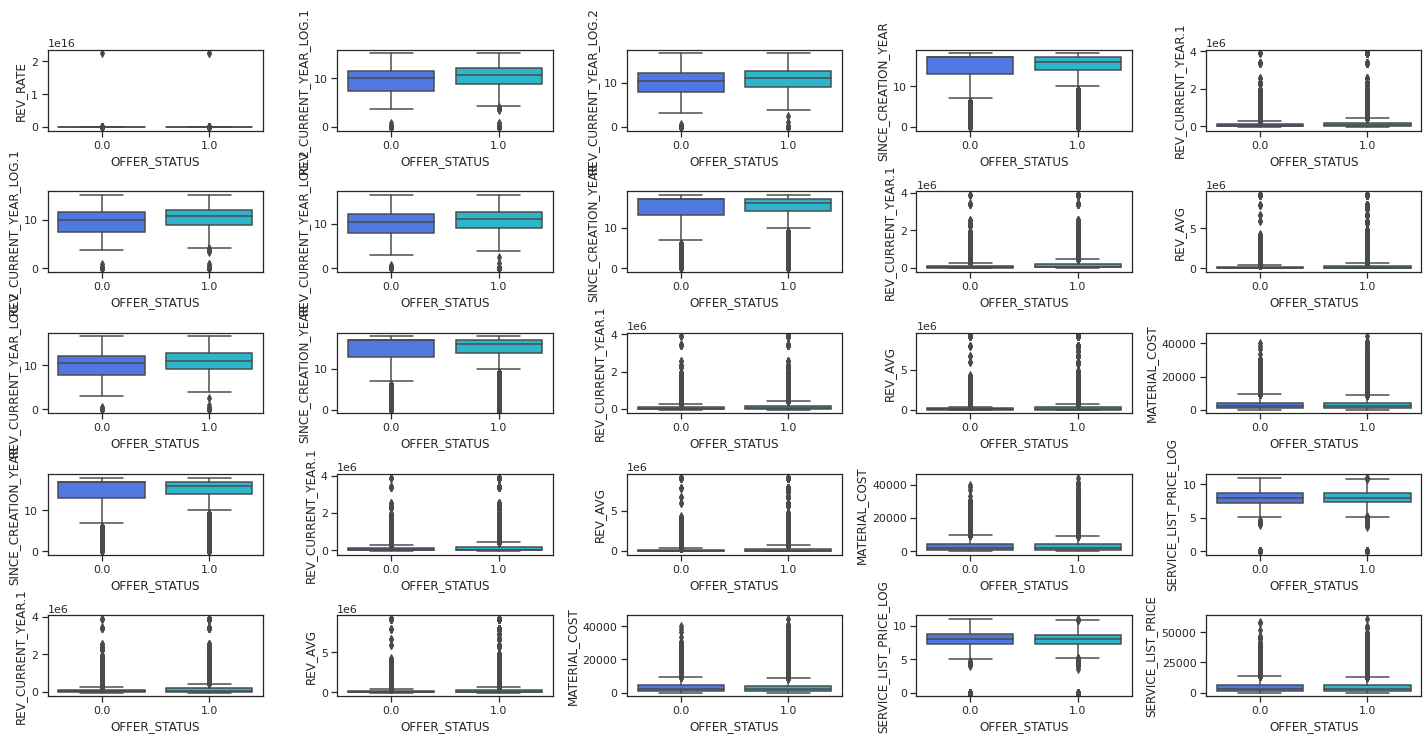

<IPython.core.display.Javascript object>

In [91]:
from pylab import rcParams


def box_plot(x, columns, data):
    matrix_indexes = [(x, y) for x in np.arange(5) for y in np.arange(5)]

    rcParams["figure.figsize"] = 20, 10
    fig, axs = plt.subplots(5, 5)
    plt.tight_layout()
    fig.subplots_adjust(top=0.7)
    sns.set(style="ticks", palette="rainbow")

    for i, j in matrix_indexes:
        sns.boxplot(x=x, y=columns[i + j], data=data, ax=axs[j, i])
    plt.tight_layout()
    plt.show()


box_plot(Y_train, numerical_columns, X_train)

In [92]:
"""
Algorithm 'HER(Hard-Edges Method)' applies induction to the elements of a value line which are:

    - lower than the 1th quantile to that quantile and
    - upper than the 99th quantile to that quantile.
    
Main aim is to diminish negative effects of outlier values on analytical operations being performed.
"""

def HardEdgeReduction(df,numerical_columns,sparse_columns,upper_quantile=0.99,lower_quantile=0.01):
    
    import pandas as pd

    import psutil, os, gc, time
    print("HardEdgeReduction process has began:\n")
    proc = psutil.Process(os.getpid())
    gc.collect()
    mem_0 = proc.memory_info().rss
    start_time = time.time()
    
    # Do outlier cleaning in only one loop
    epsilon = 0.0001 # for zero divisions

    # Define boundaries that we will use for Reduction operation

    df_outlier_cleaned = df.copy()


    print("Detected outliers will be replaced with edged quantiles/percentiles: 1% and 99%!\n")
    print("Total number of rows is: %s\n"%df_outlier_cleaned.shape[0])

    outlier_boundries_dict={}

    for col in numerical_columns:

        if col in sparse_columns:

            # First ignore the 'sparse' data points:
            nonsparse_data = pd.DataFrame(df_outlier_cleaned[df_outlier_cleaned[col] !=\
                                                             df_outlier_cleaned[col].mode()[0]][col]) 
            
            #we used only mode to catch sparse points, since we know/proved it is enough to do that.

            # Find Outlier Thresholds:
            # Note: All columns are right-skewed
            # For lower threshold (left-hand-side)
            if nonsparse_data[col].quantile(lower_quantile) < df_outlier_cleaned[col].mode()[0]: #Unexpected case
                lower_bound_sparse = nonsparse_data[col].quantile(lower_quantile)
            else:
                lower_bound_sparse = df_outlier_cleaned[col].mode()[0]
            
            # For upper threshold (right-hand-side)
            if nonsparse_data[col].quantile(upper_quantile) < df_outlier_cleaned[col].mode()[0]: #Unexpected case
                upper_bound_sparse = df_outlier_cleaned[col].mode()[0]
            else:
                upper_bound_sparse = nonsparse_data[col].quantile(upper_quantile)

            outlier_boundries_dict[col]=(lower_bound_sparse,upper_bound_sparse)

            # Inform user about the cardinality of Outlier existence:
            number_of_outliers = len(df_outlier_cleaned[(df_outlier_cleaned[col] < lower_bound_sparse) |\
                                                        (df_outlier_cleaned[col] > upper_bound_sparse)][col])
            print("Sparse: Outlier number in {} is equal to: ".format(col),round(number_of_outliers/(nonsparse_data.shape[0] -
                                                                                       nonsparse_data.isnull().sum()),2))

            # Replace Outliers with Edges --> 1% and 99%:
            if number_of_outliers > 0:

                # Replace 'left-hand-side' outliers with its 1% quantile value
                df_outlier_cleaned.loc[df_outlier_cleaned[col] < lower_bound_sparse,col] = lower_bound_sparse - epsilon # --> MAIN DF CHANGED

                # Replace 'right-hand-side' outliers with its 99% quantile value
                df_outlier_cleaned.loc[df_outlier_cleaned[col] > upper_bound_sparse,col] = upper_bound_sparse + epsilon # --> MAIN DF CHANGED

        else:
            # Find Edges:
            number_of_outliers = len(df_outlier_cleaned[(df_outlier_cleaned[col] < \
                                                         df_outlier_cleaned[col].quantile(lower_quantile))|\
                                                        (df_outlier_cleaned[col] > \
                                                         df_outlier_cleaned[col].quantile(upper_quantile))]\
                                     [col])
            print("Other: Outlier number in {} is equal to: ".format(col),round(number_of_outliers/(df[col].shape[0] -
                                                                                       df[col].isnull().sum()),2)) 

            # Replace 'Standard' outliers:
            if number_of_outliers > 0:
                # Replace all outliers with its %99 quartile
                lower_bound_sparse = df_outlier_cleaned[col].quantile(lower_quantile)
                df_outlier_cleaned.loc[df_outlier_cleaned[col] < \
                                       lower_bound_sparse,col] \
                = lower_bound_sparse  - epsilon

                upper_bound_sparse = df_outlier_cleaned[col].quantile(upper_quantile)
                df_outlier_cleaned.loc[df_outlier_cleaned[col] > \
                                       upper_bound_sparse,col] \
                = upper_bound_sparse  + epsilon

            outlier_boundries_dict[col]=(lower_bound_sparse,upper_bound_sparse)


    print('HardEdgeReduction process has been completed!')
    print("--- in %s minutes ---" % ((time.time() - start_time)/60))

    return df_outlier_cleaned, outlier_boundries_dict


<IPython.core.display.Javascript object>

In [93]:
X_train, outlier_boundries_dict = HardEdgeReduction(
    X_train, numerical_columns, sparse_columns
)

HardEdgeReduction process has began:

Detected outliers will be replaced with edged quantiles/percentiles: 1% and 99%!

Total number of rows is: 23575

Other: Outlier number in REV_RATE is equal to:  0.02
Other: Outlier number in REV_CURRENT_YEAR_LOG.1 is equal to:  0.0
Other: Outlier number in REV_CURRENT_YEAR_LOG.2 is equal to:  0.01
Other: Outlier number in SINCE_CREATION_YEAR is equal to:  0.0
Other: Outlier number in REV_CURRENT_YEAR.1 is equal to:  0.01
Other: Outlier number in REV_AVG is equal to:  0.01
Other: Outlier number in MATERIAL_COST is equal to:  0.01
Other: Outlier number in SERVICE_LIST_PRICE_LOG is equal to:  0.01
Other: Outlier number in SERVICE_LIST_PRICE is equal to:  0.01
Other: Outlier number in TOTAL_COST_LOG is equal to:  0.02
Other: Outlier number in OFFER_PRICE_LOG is equal to:  0.02
Other: Outlier number in OFFER_PRICE is equal to:  0.02
Other: Outlier number in TOTAL_COST_RATIO is equal to:  0.0
Other: Outlier number in SO_CREATED_DATE_INTEGER is equal to:

<IPython.core.display.Javascript object>

In [94]:
outlier_boundries_dict

{'REV_RATE': (0.007023547795178015, 22.78392433584137),
 'REV_CURRENT_YEAR_LOG.1': (0.0, 14.654343320121846),
 'REV_CURRENT_YEAR_LOG.2': (0.0, 16.423825089416642),
 'SINCE_CREATION_YEAR': (1.0, 18.0),
 'REV_CURRENT_YEAR.1': (0.0, 2313663.8029354257),
 'REV_AVG': (0.0, 7910616.773369983),
 'MATERIAL_COST': (0.0, 21976.767999999975),
 'SERVICE_LIST_PRICE_LOG': (0.0, 10.309763918198676),
 'SERVICE_LIST_PRICE': (0.0, 30023.363799999886),
 'TOTAL_COST_LOG': (601.2669999999999, 36654.9507999999),
 'OFFER_PRICE_LOG': (6.97914527506881, 10.798127590544404),
 'OFFER_PRICE': (1074.0, 48929.10299999994),
 'TOTAL_COST_RATIO': (1074.0, 48929.10299999994),
 'SO_CREATED_DATE_INTEGER': (1547181135.5, 1623081330.0),
 'SERVICE_COST_LOG': (0.0, 10.149802459695607),
 'ADDITIONAL_COST': (-361.8785999999999, 16390.98039999997),
 'SERVICE_COST': (0.0, 25585.05779999992)}

<IPython.core.display.Javascript object>

##  Cleaning Outliers for Test Dataset




In [95]:
# Do outlier cleaning in only one loop
epsilon = 0.0001  # for zero divisions

# Define boundaries that we will use for Reduction operation
upper_quantile = 0.99
lower_quantile = 0.01

df_test_outlier_cleaned = X_test.copy()

print(
    "Detected outliers will be replaced with edged quantiles/percentiles: 1% and 99%!\n"
)
print("Total number of rows is: %s\n" % df_test_outlier_cleaned.shape[0])

for col in numerical_columns:

    lower_bound = outlier_boundries_dict[col][0]
    upper_bound = outlier_boundries_dict[col][1]

    # Inform user about the cardinality of Outlier existence:
    number_of_outliers = len(
        df_test_outlier_cleaned[
            (df_test_outlier_cleaned[col] < lower_bound)
            | (df_test_outlier_cleaned[col] > upper_bound)
        ][col]
    )
    print(
        "Outlier number in {} is equal to: ".format(col),
        round(
            number_of_outliers
            / (
                df_test_outlier_cleaned[col].shape[0]
                - df_test_outlier_cleaned[col].isnull().sum()
            ),
            2,
        ),
    )

    # Replace Outliers with Edges --> 1% and 99%:
    if number_of_outliers > 0:

        # Replace 'left-hand-side' outliers with its 1% quantile value
        df_test_outlier_cleaned.loc[df_test_outlier_cleaned[col] < lower_bound, col] = (
            lower_bound - epsilon
        )  # --> MAIN DF CHANGED

        # Replace 'right-hand-side' outliers with its 99% quantile value
        df_test_outlier_cleaned.loc[df_test_outlier_cleaned[col] > upper_bound, col] = (
            upper_bound + epsilon
        )  # --> MAIN DF CHANGED

Detected outliers will be replaced with edged quantiles/percentiles: 1% and 99%!

Total number of rows is: 2576

Outlier number in REV_RATE is equal to:  0.01
Outlier number in REV_CURRENT_YEAR_LOG.1 is equal to:  0.19
Outlier number in REV_CURRENT_YEAR_LOG.2 is equal to:  0.08
Outlier number in SINCE_CREATION_YEAR is equal to:  0.0
Outlier number in REV_CURRENT_YEAR.1 is equal to:  0.19
Outlier number in REV_AVG is equal to:  0.08
Outlier number in MATERIAL_COST is equal to:  0.01
Outlier number in SERVICE_LIST_PRICE_LOG is equal to:  0.01
Outlier number in SERVICE_LIST_PRICE is equal to:  0.01
Outlier number in TOTAL_COST_LOG is equal to:  0.02
Outlier number in OFFER_PRICE_LOG is equal to:  0.02
Outlier number in OFFER_PRICE is equal to:  0.02
Outlier number in TOTAL_COST_RATIO is equal to:  1.0
Outlier number in SO_CREATED_DATE_INTEGER is equal to:  0.02
Outlier number in SERVICE_COST_LOG is equal to:  0.01
Outlier number in ADDITIONAL_COST is equal to:  0.02
Outlier number in SERV

<IPython.core.display.Javascript object>

In [96]:
X_test = df_test_outlier_cleaned

<IPython.core.display.Javascript object>

## Visualization After Cleaning Outlier


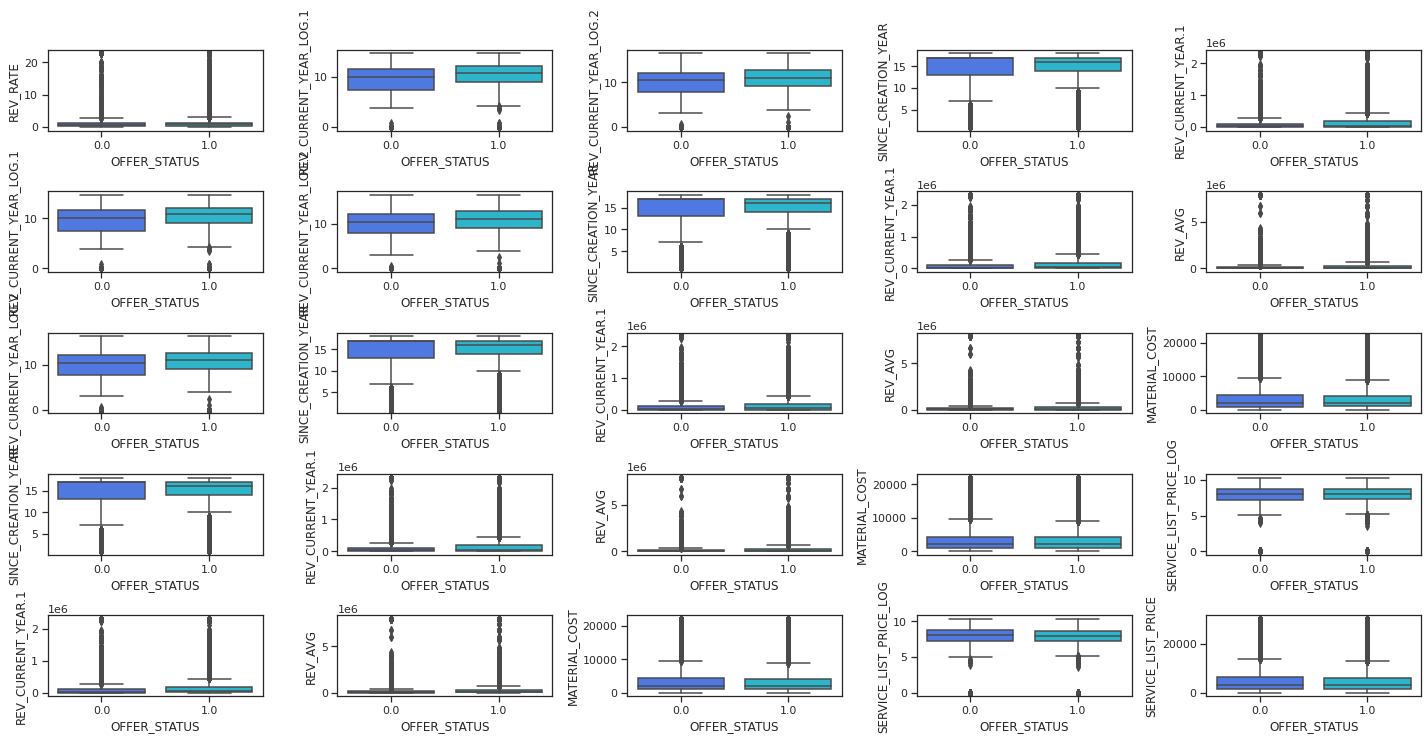

<IPython.core.display.Javascript object>

In [97]:
box_plot(Y_train, numerical_columns, X_train)

## Imputation for Missing Values

In [98]:
Zero_MR_variables_list = list(df_info[df_info["%_Missing_Value"] == 0].index)
Low_MR_variables_list = list(
    df_info[
        (df_info["%_Missing_Value"] > 0) & (df_info["%_Missing_Value"] <= 0.05)
    ].index
)
Moderate_MR_variables_list = list(
    df_info[
        (df_info["%_Missing_Value"] > 0.05) & (df_info["%_Missing_Value"] <= 0.275)
    ].index
)
High_MR_variables_list = list(
    df_info[
        (df_info["%_Missing_Value"] > 0.275) & (df_info["%_Missing_Value"] <= 0.50)
    ].index
)
Extreme_MR_variables_list = list(
    df_info[
        (df_info["%_Missing_Value"] > 0.50) & (df_info["%_Missing_Value"] <= 0.95)
    ].index
)
Drop_MR_variables_list = list(df_info[df_info["%_Missing_Value"] > 0.95].index)


print("[INFO] Number of Zero_MR_variables_list:", len(Zero_MR_variables_list))
print("[INFO] Number of Low_MR_variables_list:", len(Low_MR_variables_list))
print("[INFO] Number of Moderate_MR_variables_list:", len(Moderate_MR_variables_list))
print("[INFO] Number of High_MR_variables_list:", len(High_MR_variables_list))
print("[INFO] Number of Extreme_MR_variables_list:", len(Extreme_MR_variables_list))


assert len(Zero_MR_variables_list) + len(Low_MR_variables_list) + len(
    Moderate_MR_variables_list
) + len(High_MR_variables_list) + len(Extreme_MR_variables_list) == len(df_info)

[INFO] Number of Zero_MR_variables_list: 18
[INFO] Number of Low_MR_variables_list: 3
[INFO] Number of Moderate_MR_variables_list: 8
[INFO] Number of High_MR_variables_list: 0
[INFO] Number of Extreme_MR_variables_list: 0


<IPython.core.display.Javascript object>

In [99]:
# Simple Imputer for Low Missing Values


def SimpleImputer(df, data_info, variable_list):
    for col in variable_list:

        if col in numerical_columns:

            print("Total null values: {}".format(df[[str(col)]].isnull().sum()))

            average = float(df[col].mean())
            std = float(df[col].std())
            count_nan = int(df[col].isnull().sum())
            rand = np.random.normal(loc=average, scale=std, size=count_nan)
            slice_col = pd.Series(df[col].copy())
            slice_col[pd.isnull(slice_col)] = rand
            df[col] = slice_col

            print("Numerical variable {} have been imputed.".format(col))

        else:

            print("Total null values: {}".format(df[[str(col)]].isnull().sum()))
            df.loc[df.loc[:, col].isnull(), col] = np.random.choice(
                sorted(list(df.loc[:, col].dropna().unique())),
                size=int(df.loc[df.loc[:, col].isnull(), col].shape[0]),
                p=[
                    pd.Series(
                        df.groupby(col).size() / df.loc[:, col].dropna().shape[0]
                    ).iloc[i]
                    for i in np.arange(0, len(df.loc[:, col].dropna().unique()))
                ],
            )

            print("Categorical variable {} have been imputed.".format(col))




<IPython.core.display.Javascript object>

In [100]:
print(Low_MR_variables_list)

SimpleImputer(X_train, df_info, Low_MR_variables_list)

['SALES_OFFICE', 'SALES_OFFICE_REDUCED', 'SALES_LOCATION']
Total null values: SALES_OFFICE    36
dtype: int64
Categorical variable SALES_OFFICE have been imputed.
Total null values: SALES_OFFICE_REDUCED    36
dtype: int64
Categorical variable SALES_OFFICE_REDUCED have been imputed.
Total null values: SALES_LOCATION    35
dtype: int64
Categorical variable SALES_LOCATION have been imputed.


<IPython.core.display.Javascript object>

In [101]:
SimpleImputer(X_test, df_info, Low_MR_variables_list)

Total null values: SALES_OFFICE    2
dtype: int64
Categorical variable SALES_OFFICE have been imputed.
Total null values: SALES_OFFICE_REDUCED    2
dtype: int64
Categorical variable SALES_OFFICE_REDUCED have been imputed.
Total null values: SALES_LOCATION    2
dtype: int64
Categorical variable SALES_LOCATION have been imputed.


<IPython.core.display.Javascript object>

In [102]:
MissingUniqueStatistics(X_train.loc[:, Low_MR_variables_list])

,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,#_Uniques_Values
Variable,,,,,
SALES_OFFICE,23575,0,0.0,object,38
SALES_OFFICE_REDUCED,23575,0,0.0,object,34
SALES_LOCATION,23575,0,0.0,object,44


<IPython.core.display.Javascript object>

In [103]:
MissingUniqueStatistics(X_test.loc[:, Low_MR_variables_list])

,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,#_Uniques_Values
Variable,,,,,
SALES_OFFICE,2576,0,0.0,object,36
SALES_OFFICE_REDUCED,2576,0,0.0,object,34
SALES_LOCATION,2576,0,0.0,object,38


<IPython.core.display.Javascript object>

## STRING CONVERSION


### MEAN ENCODING


In [104]:
class KFoldTargetEncoderTrain(base.BaseEstimator,
                               base.TransformerMixin):
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)
        
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = True, random_state=42)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = \
            X_val[self.colnames].map(X_tr.groupby(self.colnames)
                                     [self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'\
                  .format(col_mean_name,self.targetName,
                          np.corrcoef(X[self.targetName].values,
                                      encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
        return X
def StringConverterTrain(df,target_name,variable_list):
    for col in variable_list:
        targetc = KFoldTargetEncoderTrain(col,target_name,n_fold=4)
        new_train = targetc.fit_transform(df)
    return new_train


<IPython.core.display.Javascript object>

In [105]:
nominal_variable = list(df_info[df_info["Variable_Type"] == "Nominal"].index)
nominal_lst = [
    item
    for item in Moderate_MR_variables_list
    + High_MR_variables_list
    + Extreme_MR_variables_list
    if item in nominal_variable
]
if "OFFER_STATUS" in nominal_lst:
    nominal_lst.remove("OFFER_STATUS")

nominal_lst

['CURRENCY']

<IPython.core.display.Javascript object>

In [106]:
df_trial = pd.concat([X_train, Y_train], axis=1).copy()
df_output_train = StringConverterTrain(
    df=df_trial, target_name="OFFER_STATUS", variable_list=nominal_lst
)

Correlation between the new feature, CURRENCY_Kfold_Target_Enc and, OFFER_STATUS is 0.06629006239856437.


<IPython.core.display.Javascript object>

In [107]:
for item in nominal_lst:
    print(df_output_train.loc[:, [item + "_Kfold_Target_Enc"]].isnull().sum())

CURRENCY_Kfold_Target_Enc    0
dtype: int64


<IPython.core.display.Javascript object>

In [108]:
for item in nominal_lst:
    X_train[item] = df_output_train[item + "_Kfold_Target_Enc"]

<IPython.core.display.Javascript object>

### Mean Encoding for nominal variables(non missing value)

In [109]:
df_encoding = pd.concat([X_train, Y_train], axis=1).copy()
categorical_non_missing_columns = type_separator(
    df_encoding[get_non_null_columns(df_encoding)], False
)["cat"]

if "OFFER_STATUS" in categorical_non_missing_columns:
    categorical_non_missing_columns.remove("OFFER_STATUS")
print(categorical_non_missing_columns)

df_encoding_train = StringConverterTrain(
    df=df_encoding,
    target_name="OFFER_STATUS",
    variable_list=categorical_non_missing_columns,
)

for item in categorical_non_missing_columns:
    X_train[item] = df_encoding_train[item + "_Kfold_Target_Enc"]

['BUSINESS_TYPE', 'OFFER_TYPE', 'OFFER_TYPE_REDUCED_1', 'OFFER_TYPE_REDUCED_2', 'SALES_LOCATION', 'SALES_OFFICE', 'SALES_OFFICE_REDUCED', 'TECH_REDUCED_1', 'TECH', 'PRICE_LIST']
Correlation between the new feature, BUSINESS_TYPE_Kfold_Target_Enc and, OFFER_STATUS is 0.2494749966788201.
Correlation between the new feature, OFFER_TYPE_Kfold_Target_Enc and, OFFER_STATUS is 0.25429305277922803.
Correlation between the new feature, OFFER_TYPE_REDUCED_1_Kfold_Target_Enc and, OFFER_STATUS is 0.22402048884627293.
Correlation between the new feature, OFFER_TYPE_REDUCED_2_Kfold_Target_Enc and, OFFER_STATUS is 0.21785065289767036.
Correlation between the new feature, SALES_LOCATION_Kfold_Target_Enc and, OFFER_STATUS is 0.19883589349728142.
Correlation between the new feature, SALES_OFFICE_Kfold_Target_Enc and, OFFER_STATUS is 0.19935576035735153.
Correlation between the new feature, SALES_OFFICE_REDUCED_Kfold_Target_Enc and, OFFER_STATUS is 0.19818064289749657.
Correlation between the new feature

<IPython.core.display.Javascript object>

In [110]:
for item in categorical_non_missing_columns:
    print(df_encoding_train.loc[:, [item + "_Kfold_Target_Enc"]].isnull().sum())

BUSINESS_TYPE_Kfold_Target_Enc    0
dtype: int64
OFFER_TYPE_Kfold_Target_Enc    0
dtype: int64
OFFER_TYPE_REDUCED_1_Kfold_Target_Enc    0
dtype: int64
OFFER_TYPE_REDUCED_2_Kfold_Target_Enc    0
dtype: int64
SALES_LOCATION_Kfold_Target_Enc    0
dtype: int64
SALES_OFFICE_Kfold_Target_Enc    0
dtype: int64
SALES_OFFICE_REDUCED_Kfold_Target_Enc    0
dtype: int64
TECH_REDUCED_1_Kfold_Target_Enc    0
dtype: int64
TECH_Kfold_Target_Enc    0
dtype: int64
PRICE_LIST_Kfold_Target_Enc    0
dtype: int64


<IPython.core.display.Javascript object>

In [111]:
MissingUniqueStatistics(X_train)

,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,#_Uniques_Values
Variable,,,,,
REV_RATE,17075,6500,0.2757,float64,5445
REV_CURRENT_YEAR_LOG.1,20724,2851,0.1209,float64,6241
REV_CURRENT_YEAR_LOG.2,20734,2841,0.1205,float64,6026
SINCE_CREATION_YEAR,20785,2790,0.1183,float64,20
REV_AVG,20785,2790,0.1183,float64,6750
REV_CURRENT_YEAR.1,20785,2790,0.1183,float64,6242
OFFER_PRICE_LOG,23575,0,0.0000,float64,16711
CURRENCY,23575,0,0.0000,float64,17
MATERIAL_COST,23575,0,0.0000,float64,7026


<IPython.core.display.Javascript object>

# **String Converter for Test Dataset**

In [112]:
df_output_test = X_test.copy()
mean_of_target = df_output_train["OFFER_STATUS"].copy().mean()
target_mean_list = nominal_lst
for col in target_mean_list:
    df_output_test[col] = df_output_test[col].map(
        df_output_train.groupby(col)[col + "_Kfold_Target_Enc"].mean()
    )
    df_output_test[col].fillna(mean_of_target, inplace=True)

<IPython.core.display.Javascript object>

In [113]:
for item in nominal_lst:
    print(df_output_test.loc[:, [item]].isnull().sum())

CURRENCY    0
dtype: int64


<IPython.core.display.Javascript object>

In [114]:
X_test[nominal_lst] = df_output_test[nominal_lst]

<IPython.core.display.Javascript object>

In [115]:
X_test_encoder = X_test.copy()
mean_of_target = df_encoding_train["OFFER_STATUS"].copy().mean()
target_mean_list = categorical_non_missing_columns
for col in target_mean_list:
    X_test_encoder[col + "_Kfold_Target_Enc"] = X_test_encoder[col].map(
        df_encoding_train.groupby(col)[col + "_Kfold_Target_Enc"].mean()
    )
    X_test_encoder[col + "_Kfold_Target_Enc"].fillna(mean_of_target, inplace=True)

<IPython.core.display.Javascript object>

In [116]:
for item in categorical_non_missing_columns:
    X_test[item] = X_test_encoder[item + "_Kfold_Target_Enc"]

MissingUniqueStatistics(X_test[categorical_non_missing_columns])

,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,#_Uniques_Values
Variable,,,,,
BUSINESS_TYPE,2576,0,0.0,float64,8
OFFER_TYPE,2576,0,0.0,float64,27
OFFER_TYPE_REDUCED_1,2576,0,0.0,float64,18
OFFER_TYPE_REDUCED_2,2576,0,0.0,float64,14
SALES_LOCATION,2576,0,0.0,float64,38
SALES_OFFICE,2576,0,0.0,float64,36
SALES_OFFICE_REDUCED,2576,0,0.0,float64,34
TECH_REDUCED_1,2576,0,0.0,float64,4
TECH,2576,0,0.0,float64,6


<IPython.core.display.Javascript object>

## Modal Based Imputation

In [117]:
def MBI(df, columns, train_or_test, lst_numerical):

    data_binary_encoded = df.copy()
    le = LabelEncoder()

    if columns:
        for col in columns:
            if train_or_test == "test":
                le.fit(X_train[col].copy().astype(str))
                data_binary_encoded[col] = le.transform(df[col].copy().astype(str))
            else:
                data_binary_encoded[col] = le.fit_transform(df[col].copy().astype(str))

    data_scaled = data_binary_encoded.copy()

    for col in numerical_columns:

        scaler = StandardScaler()

        if train_or_test == "test":

            scaler.fit(np.array(X_train.loc[:, col]).reshape(-1, 1))
            data_scaled.loc[:, col] = scaler.transform(
                np.array(data_scaled.loc[:, col]).reshape(-1, 1)
            )

        else:
            data_scaled.loc[:, col] = scaler.fit_transform(
                np.array(data_scaled.loc[:, col]).reshape(-1, 1)
            )

    for col in lst_numerical:

        target_dropped_fullcases = (
            data_scaled.drop(col, axis=1)
            .loc[
                :,
                list(
                    set(Zero_MR_variables_list + Low_MR_variables_list)
                    - set(["CLASS", "KEY", "CLNHGVS"])
                ),
            ]
            .copy()
        )

        target = data_scaled.loc[:, col]
        null_mask = target.isna()
        print(col)

        if col in numerical_columns:

            mlp = MLPRegressor(
                hidden_layer_sizes=(
                    100,
                    10,
                ),
                activation="tanh",
                solver="adam",
                learning_rate="adaptive",
                max_iter=1000,
                learning_rate_init=0.01,
                alpha=0.01,
                early_stopping=False,
            )
        else:
            mlp = MLPClassifier(
                hidden_layer_sizes=(
                    100,
                    10,
                ),
                activation="tanh",
                solver="adam",
                learning_rate="adaptive",
                max_iter=1000,
                learning_rate_init=0.01,
                alpha=0.01,
                early_stopping=False,
            )

        mlp.fit(target_dropped_fullcases[~null_mask], target[~null_mask])
        data_scaled.loc[null_mask, col] = mlp.predict(
            target_dropped_fullcases[null_mask]
        )

    print(data_scaled.loc[:, lst_numerical].isnull().sum())
    return data_scaled

<IPython.core.display.Javascript object>

In [118]:
moderate_numerical_variables = [
    item for item in Moderate_MR_variables_list if item in numerical_columns
]
moderate_numerical_variables

['REV_RATE',
 'REV_CURRENT_YEAR_LOG.1',
 'REV_CURRENT_YEAR_LOG.2',
 'SINCE_CREATION_YEAR',
 'REV_CURRENT_YEAR.1',
 'REV_AVG']

<IPython.core.display.Javascript object>

In [119]:
assert "cat" not in type_separator(X_train, False), print(
    "All categorical variables should have encoded, check encodings!"
)
assert "cat" not in type_separator(X_train, False), print(
    "All categorical variables should have encoded, check encodings!"
)

<IPython.core.display.Javascript object>

In [120]:
X_train_scaled = MBI(X_train, None, "train", moderate_numerical_variables)

REV_RATE
REV_CURRENT_YEAR_LOG.1
REV_CURRENT_YEAR_LOG.2
SINCE_CREATION_YEAR
REV_CURRENT_YEAR.1
REV_AVG
REV_RATE                  0
REV_CURRENT_YEAR_LOG.1    0
REV_CURRENT_YEAR_LOG.2    0
SINCE_CREATION_YEAR       0
REV_CURRENT_YEAR.1        0
REV_AVG                   0
dtype: int64


<IPython.core.display.Javascript object>

In [121]:
X_train_scaled

,ADDITIONAL_COST,BUSINESS_TYPE,OFFER_TYPE,OFFER_TYPE_REDUCED_1,OFFER_TYPE_REDUCED_2,REV_AVG,REV_CURRENT_YEAR.1,REV_CURRENT_YEAR_LOG.1,REV_CURRENT_YEAR_LOG.2,REV_RATE,SALES_LOCATION,SALES_OFFICE,SALES_OFFICE_REDUCED,SERVICE_COST,SERVICE_COST_LOG,SO_CREATED_DATE_INTEGER,TOTAL_COST_RATIO,OFFER_PRICE_LOG,OFFER_PRICE,TECH_REDUCED_1,TECH,TOTAL_COST_LOG,PRICE_LIST,SERVICE_LIST_PRICE,SERVICE_LIST_PRICE_LOG,MATERIAL_COST,CURRENCY,SINCE_CREATION_YEAR
0,-0.817332,0.844418,0.793431,0.793431,0.793431,-0.349041,-0.467415,-0.065834,0.138200,-0.392319,0.881549,0.881549,0.881549,-0.630280,-0.470518,-1.509838,0.894823,-1.313176,-0.787198,0.752851,0.752851,-0.719959,0.832332,-0.625925,-0.153280,-0.580971,0.816772,0.575068
1,2.069347,0.602909,0.690600,0.690600,0.690600,-0.370382,-0.493681,-2.366365,-2.194543,-0.141386,0.852062,0.851108,0.851184,0.954912,0.914591,-1.509825,-0.155702,1.518757,1.656768,0.719745,0.719745,1.377445,0.600326,1.738733,0.910502,1.434763,0.811076,0.575068
2,-0.204763,0.843403,0.902470,0.902470,0.902470,-0.022793,-0.147374,-0.103579,0.109497,-0.205260,0.888235,0.888104,0.887059,-0.215845,0.440277,-1.509592,-0.498878,0.024745,-0.341617,0.853821,0.853821,-0.374240,0.830703,-0.465201,0.072056,-0.429329,0.803224,0.211436
3,-0.547881,0.822903,0.908159,0.908159,0.908159,-0.347688,-0.461961,-0.018962,0.141852,-0.372395,0.841363,0.842353,0.841981,-0.088863,0.532048,-1.509451,-1.716789,-0.363141,-0.533844,0.857169,0.857169,-0.489864,0.832678,-0.819472,-0.832722,-0.793270,0.824412,0.799024
4,0.567188,0.844418,0.904640,0.904640,0.904640,-0.361714,-0.475827,-0.161749,-0.119924,-0.271196,0.759332,0.758841,0.759214,0.204561,0.684144,-1.509386,-0.211182,0.830840,0.385243,0.857939,0.857939,0.286356,0.832332,0.162532,0.492420,0.298555,0.822388,0.575068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26146,-0.383448,0.877907,0.806610,0.806610,0.806610,-0.351865,-0.406442,0.232419,-0.464738,4.648486,0.846523,0.846523,0.846523,1.182218,0.963289,1.900527,-1.028136,0.868320,0.434853,0.857169,0.857169,0.757984,0.826271,0.112049,0.469849,0.019188,0.810099,-0.544715
26147,-0.560627,0.619184,0.866426,0.866426,0.866426,-0.078051,-0.238819,0.498804,0.746782,-0.429711,0.809633,0.808756,0.808756,-0.496089,0.082628,1.900527,0.665090,-0.179139,-0.451620,0.854188,0.854188,-0.372592,0.828328,-0.227924,0.278772,-0.095765,0.816667,-0.544715
26148,-0.653547,0.888114,0.810844,0.810844,0.810844,0.388517,0.874313,0.916346,0.903896,-0.315455,0.738532,0.737931,0.738532,-0.669230,-2.416137,1.900527,1.380532,-0.853665,-0.693164,0.854188,0.854188,-0.661670,0.828328,-0.398129,0.140652,-0.427060,0.830333,0.351111
26149,0.980147,0.877907,0.870896,0.870896,0.870896,-0.262986,-0.429295,0.156944,0.536065,-0.454017,0.707965,0.705357,0.705357,-0.276540,0.386864,1.900527,0.794322,1.051540,0.705115,0.857169,0.857169,0.545928,0.826271,1.327379,0.833016,1.346786,0.830245,0.351111


<IPython.core.display.Javascript object>

In [122]:
X_test_scaled = MBI(X_test, None, "test", moderate_numerical_variables)

REV_RATE
REV_CURRENT_YEAR_LOG.1
REV_CURRENT_YEAR_LOG.2
SINCE_CREATION_YEAR
REV_CURRENT_YEAR.1
REV_AVG
REV_RATE                  0
REV_CURRENT_YEAR_LOG.1    0
REV_CURRENT_YEAR_LOG.2    0
SINCE_CREATION_YEAR       0
REV_CURRENT_YEAR.1        0
REV_AVG                   0
dtype: int64


<IPython.core.display.Javascript object>

In [123]:
X_test_scaled

,ADDITIONAL_COST,BUSINESS_TYPE,OFFER_TYPE,OFFER_TYPE_REDUCED_1,OFFER_TYPE_REDUCED_2,REV_AVG,REV_CURRENT_YEAR.1,REV_CURRENT_YEAR_LOG.1,REV_CURRENT_YEAR_LOG.2,REV_RATE,SALES_LOCATION,SALES_OFFICE,SALES_OFFICE_REDUCED,SERVICE_COST,SERVICE_COST_LOG,SO_CREATED_DATE_INTEGER,TOTAL_COST_RATIO,OFFER_PRICE_LOG,OFFER_PRICE,TECH_REDUCED_1,TECH,TOTAL_COST_LOG,PRICE_LIST,SERVICE_LIST_PRICE,SERVICE_LIST_PRICE_LOG,MATERIAL_COST,CURRENCY,SINCE_CREATION_YEAR
5,0.161387,0.611482,0.905231,0.905231,0.905231,0.220890,0.623572,0.866036,0.841623,-0.301296,0.759113,0.758840,0.758730,2.505819,1.163813,-1.508916,3619.324224,1.383409,1.335462,0.855780,0.855780,1.751488,0.832185,0.183403,0.501433,0.298555,0.827165,0.351111
8,4.183963,0.843905,0.774074,0.774074,0.774074,4.575222,5.299132,1.274998,1.232629,-0.056819,0.759113,0.758840,0.758730,4.072726,1.312952,-1.505939,3619.324224,2.143747,3.833103,0.722760,0.722760,3.145216,0.605072,1.279216,0.823011,1.032356,0.809630,0.127155
13,-0.425457,0.843905,0.772700,0.772700,0.772700,0.303897,1.407387,0.998114,0.791600,-0.079610,0.759113,0.758840,0.758730,-0.182360,0.466759,-1.504854,3619.324224,0.094611,-0.298632,0.753637,0.753637,-0.221942,0.832185,-0.290563,0.232698,-0.186701,0.827165,0.575068
34,0.299560,0.476941,0.782745,0.782745,0.782745,0.303897,1.407387,0.998114,0.791600,-0.079610,0.759113,0.758840,0.758730,0.166669,0.667664,-1.501837,3619.324224,0.831668,0.386320,0.753637,0.753637,0.401596,0.832185,0.412626,0.590142,0.556717,0.827165,0.575068
35,-0.717774,0.843905,0.782745,0.782745,0.782745,-0.336910,-0.424249,0.175691,0.182561,-0.268435,0.759113,0.758840,0.758730,-0.666871,-1.483627,-1.501475,3619.324224,-1.164238,-0.761175,0.753637,0.753637,-0.726883,0.832185,-0.611655,-0.128065,-0.550642,0.821551,0.575068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26018,0.178113,0.879724,0.712970,0.712970,0.712970,-0.336833,-0.453863,0.037533,0.242460,-0.397273,0.848077,0.848077,0.848090,-0.317870,0.345539,1.218606,3619.324224,0.765045,0.302398,0.855780,0.855780,0.339066,0.827726,1.032332,0.767932,1.012334,0.827165,0.351111
26032,-0.419126,0.619831,0.812844,0.685674,0.703771,-0.370382,-0.493681,-2.366365,-2.194543,-0.152657,0.848077,0.848077,0.848090,0.409853,0.762590,1.246043,3619.324224,0.308526,-0.147355,0.855780,0.855780,-0.018847,0.827726,-0.539409,-0.018351,-0.508922,0.821551,0.351111
26049,-0.476878,0.887483,0.869112,0.869112,0.869112,-0.286955,-0.383220,0.291062,0.438966,-0.381409,0.717230,0.717230,0.717230,-0.616933,-0.361464,1.398196,3619.324224,-0.270774,-0.494402,0.855780,0.855780,-0.466394,0.827726,-0.079153,0.372417,-0.127005,0.821551,-0.768671
26057,4.183963,0.879724,0.809297,0.809297,0.809297,-0.318857,-0.352290,0.352403,0.221272,-0.104330,0.808438,0.807771,0.807771,2.171902,1.122500,1.413373,3619.324224,2.143747,3.833103,0.855780,0.855780,3.685436,0.827726,4.480916,1.235176,4.274840,0.821551,0.351111


<IPython.core.display.Javascript object>

In [124]:
MissingUniqueStatistics(X_train_scaled)

,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,#_Uniques_Values
Variable,,,,,
ADDITIONAL_COST,23575,0,0.0,float64,21417
BUSINESS_TYPE,23575,0,0.0,float64,36
CURRENCY,23575,0,0.0,float64,17
MATERIAL_COST,23575,0,0.0,float64,7026
SERVICE_LIST_PRICE_LOG,23575,0,0.0,float64,8126
SERVICE_LIST_PRICE,23575,0,0.0,float64,8126
PRICE_LIST,23575,0,0.0,float64,16
TOTAL_COST_LOG,23575,0,0.0,float64,20693
TECH,23575,0,0.0,float64,21


<IPython.core.display.Javascript object>

In [125]:
assert get_null_columns(X_train_scaled) == [], print(
    "There are some missing values left!"
)
assert get_null_columns(X_test_scaled) == [], print(
    "There are some missing values left!"
)

<IPython.core.display.Javascript object>

# Manual Feature Importance

<AxesSubplot:>

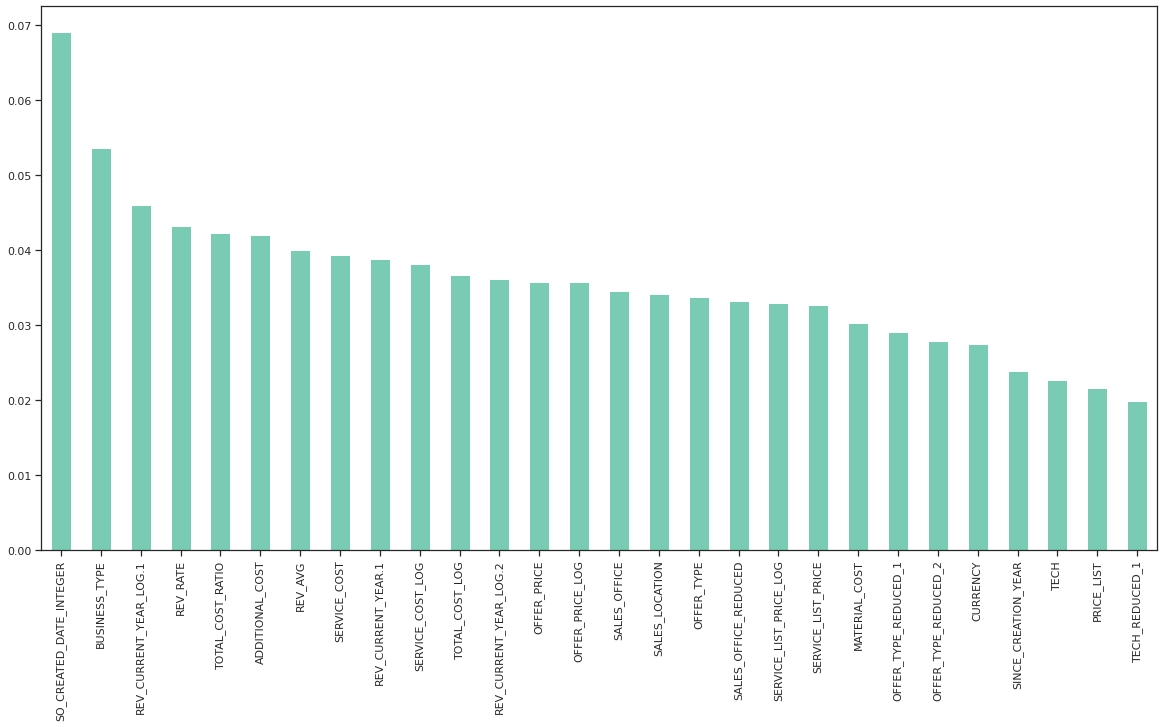

<IPython.core.display.Javascript object>

In [126]:
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train_scaled, Y_train)

features = X_train_scaled.columns
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20, 10))
feat_importances = pd.Series(importances, index=features)
feat_importances.nlargest(len(indices)).plot(kind="bar", color="#79CCB3")

In [127]:
manual_classifier_try = False
if manual_classifier_try:

    # Creating an empty Dataframe with Scores
    df_accur_roc_score = pd.DataFrame(columns=["Roc_Auc_Score"])

    import matplotlib.pyplot as plt
    from sklearn import metrics
    from sklearn.linear_model import LogisticRegression
    import xgboost as xgb
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from lightgbm import LGBMClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.experimental import enable_hist_gradient_boosting
    from sklearn.ensemble import HistGradientBoostingClassifier

    ## **LogisticRegression**
    clf = LogisticRegression(random_state=0)
    clf.fit(X_train_scaled, Y_train)
    y_preds = clf.predict_proba(X_test_scaled)
    preds = y_preds[:, 1]
    fpr, tpr, _ = metrics.roc_curve(Y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    df_accur_roc_score.loc["Logistic_regression"] = [auc_score]
    print(
        "[INFO] BAC SCORE",
        metrics.balanced_accuracy_score(Y_test, clf.predict(X_test_scaled)),
    )

    ## **XGBoost Classifier**

    xgb_model = xgb.XGBClassifier(
        n_estimators=150,
        random_state=0,
        learning_rate=0.25,
        eta=0.4,
        booster="gbtree",
        base_score=0.8,
        colsample_bylevel=0.9009229642844634,
        gamma=0.49967765132613584,
        max_depth=6,
        min_child_weight=7,
        reg_lambda=0.27611902459972926,
        subsample=0.9300916052594785,
    )
    xgb_model.fit(X_train_scaled, Y_train)
    y_preds = xgb_model.predict_proba(X_test_scaled)
    preds = y_preds[:, 1]
    fpr, tpr, _ = metrics.roc_curve(Y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    df_accur_roc_score.loc["XGBoost_Classifier"] = [auc_score]
    print(
        "[INFO] xgb_model,BAC SCORE",
        metrics.balanced_accuracy_score(Y_test, xgb_model.predict(X_test_scaled)),
    )

    ## **KNeighbors Classifier**

    knn = KNeighborsClassifier()
    knn.fit(X_train_scaled, Y_train)
    y_preds = knn.predict_proba(X_test_scaled)
    preds = y_preds[:, 1]
    fpr, tpr, _ = metrics.roc_curve(Y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    df_accur_roc_score.loc["KNeighborsClassifier"] = [auc_score]
    print(
        "[INFO] KNeighborsClassifier,BAC SCORE",
        metrics.balanced_accuracy_score(Y_test, knn.predict(X_test_scaled)),
    )

    ## **Decision Tree Classifier**

    reg_dtr = DecisionTreeClassifier(random_state=0)
    reg_dtr.fit(X_train_scaled, Y_train)
    y_preds = reg_dtr.predict_proba(X_test_scaled)
    preds = y_preds[:, 1]
    fpr, tpr, _ = metrics.roc_curve(Y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    df_accur_roc_score.loc["DecisionTreeClassifier"] = [auc_score]
    print(
        "[INFO] DecisionTreeClassifier,BAC SCORE",
        metrics.balanced_accuracy_score(Y_test, reg_dtr.predict(X_test_scaled)),
    )
    ##  **LightGBM Classifier**
    lgbm = LGBMClassifier(
        max_depth=6,
        n_estimators=100,
        random_state=0,
        learning_rate=0.1,
        eta=0.4,
        base_score=0.8,
        colsample_bylevel=0.9009229642844634,
        gamma=0.49967765132613584,
        min_child_weight=9,
        reg_lambda=0.27611902459972926,
        subsample=0.9300916052594785,
        min_samples_split=2,
        # min_samples_leaf=0.1,
    )
    lgbm.fit(X_train_scaled, Y_train)
    y_preds = lgbm.predict_proba(X_test_scaled)
    preds = y_preds[:, 1]
    fpr, tpr, _ = metrics.roc_curve(Y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    df_accur_roc_score.loc["LGBMClassifier"] = [auc_score]
    print(
        "[INFO] BAC SCORE",
        metrics.balanced_accuracy_score(Y_test, lgbm.predict(X_test_scaled)),
    )
    ## Gradient Boosting Classifier
    gradient_boosting_clf = GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=7, random_state=0
    ).fit(X_train_scaled, Y_train)
    y_preds = gradient_boosting_clf.predict_proba(X_test_scaled)
    preds = y_preds[:, 1]
    fpr, tpr, _ = metrics.roc_curve(Y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    df_accur_roc_score.loc["GradientBoostingClassifier"] = [auc_score]
    print(
        "[INFO] LGBMClassifier,BAC SCORE",
        metrics.balanced_accuracy_score(
            Y_test, gradient_boosting_clf.predict(X_test_scaled)
        ),
    )

    ## **Hist Gradient Boosting Classifier**

    hist_gradient_boosting_clf = HistGradientBoostingClassifier(
        learning_rate=0.25, max_depth=4, random_state=0
    ).fit(X_train_scaled, Y_train)
    y_preds = hist_gradient_boosting_clf.predict_proba(X_test_scaled)
    preds = y_preds[:, 1]
    fpr, tpr, _ = metrics.roc_curve(Y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    df_accur_roc_score.loc["HistGradientBoostingClassifier"] = [auc_score]
    print(
        "[INFO] HistGradientBoostingClassifier,BAC SCORE",
        metrics.balanced_accuracy_score(
            Y_test, hist_gradient_boosting_clf.predict(X_test_scaled)
        ),
    )

    print(df_accur_roc_score)
    df_accur_roc_score.sort_values(by=["Roc_Auc_Score"], ascending=False).plot(
        kind="bar",
        y="Roc_Auc_Score",
        figsize=(20, 8),
        color="#79ccb3",
        rot=0,
        title="Model outputs by roc score before feature importance",
    )

<IPython.core.display.Javascript object>

## Autosklearn

In [128]:
X_for_boruta = pd.concat([X_train_scaled, X_test_scaled])

<IPython.core.display.Javascript object>

In [129]:
Y_for_boruta = pd.concat([Y_train, Y_test])

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.ensemble import RandomForestClassifier


# define random forest classifier
forest = RandomForestClassifier(n_jobs=-1, class_weight="balanced")
forest.fit(X_for_boruta, Y_for_boruta)


from boruta import BorutaPy

# define Boruta feature selection method
feat_selector = BorutaPy(
    forest,
    # n_jobs=-1,
    n_estimators="auto",
    verbose=2,
    random_state=42,
)


feat_selector.fit(
    X_for_boruta.to_numpy(), Y_for_boruta.to_numpy()
)  # find all relevant features
print(feat_selector.support_)  # check selected features
print(feat_selector.ranking_)  # check ranking of features
# check selected features
a = list(
    zip(
        list(feat_selector.ranking_),
        list(feat_selector.support_),
        list(X_for_boruta.columns),
    )
)

[", # ".join(map(str, [f'{x[2]}", # ', x[0], x[1]])) for x in sorted(a)]


In [130]:
boruta_reduced_columns = [
    "ADDITIONAL_COST",  # , # 1, # True',
    "BUSINESS_TYPE",  # , # 1, # True',
    "OFFER_TYPE",  # , # 1, # True',
    "OFFER_TYPE_REDUCED_1",  # , # 1, # True',
    "OFFER_TYPE_REDUCED_2",  # , # 1, # True',
    "REV_AVG",  # , # 1, # True',
    "REV_CURRENT_YEAR.1",  # , # 1, # True',
    "REV_CURRENT_YEAR_LOG.1",  # , # 1, # True',
    "REV_CURRENT_YEAR_LOG.2",  # , # 1, # True',
    "REV_RATE",  # , # 1, # True',
    "SALES_LOCATION",  # , # 1, # True',
    "SALES_OFFICE",  # , # 1, # True',
    "SALES_OFFICE_REDUCED",  # , # 1, # True',
    "SERVICE_COST",  # , # 1, # True',
    "SERVICE_COST_LOG",  # , # 1, # True',
    "SO_CREATED_DATE_INTEGER",  # , # 1, # True',
    # "SO_CREATED_DATE_SCALED",  # , # 1, # True',
    "TOTAL_COST_RATIO",  # , # 1, # True',
    "OFFER_PRICE_LOG",  # , # 2, # False',
    "OFFER_PRICE",  # , # 3, # False',
    "TECH_REDUCED_1",  # , # 4, # False',
    # "REV_CURRENT_YEAR.2",  # , # 5, # False',
    # "TOTAL_COST",  # , # 5, # False',
    "TECH",  # , # 7, # False',
    "TOTAL_COST_LOG",  # , # 7, # False',
    "PRICE_LIST",  # , # 9, # False',
    "SERVICE_LIST_PRICE",  # , # 9, # False',
    "SERVICE_LIST_PRICE_LOG",  # , # 11, # False',
    # "MATERIAL_COST_LOG",  # , # 12, # False',
    "MATERIAL_COST",  # , # 13, # False',
    "CURRENCY",  # , # 14, # False',
    "SINCE_CREATION_YEAR",  # , # 15, # False',
    # "CREATION_YEAR",  # , # 16, # False',
    # "CREATION_YEAR_LOG",  # , # 16, # False',
    # "SINCE_CREATION_YEAR_LOG",  # , # 18, # False',
    #########################################################33
    # 'TECH_REDUCED_2_IS_F', # , # 19, # False',
    # 'OWNERSHIP_NA_AS_NO_INFO', # , # 21, # False',
    # 'TOTAL_COSTS_PRODUCT', # , # 21, # False',
    # 'TOTAL_COSTS_PRODUCT_LOG', # , # 21, # False',
    # 'OWNERSHIP_NA_AS_NO_INFO_REDUCED', # , # 23, # False',
    # 'OWNERSHIP', # , # 24, # False',
    # 'OWNERSHIP_REDUCED', # , # 24, # False',
    # 'OWNERSHIP_NO_INFO_AS_NA_REDUCED', # , # 26, # False',
    # 'OWNERSHIP_NO_INFO_AS_NA', # , # 27, # False',
    # 'IS_COUNTRY_CODE_CH', # , # 28, # False',
    # 'HAS_END_CUSTOMER', # , # 29, # False',
    # 'IS_NA_REV_RATE', # , # 30, # False',
    # 'IS_NA_REV_AVG', # , # 31, # False',
    # 'HAS_COSTS_PRODUCT_D', # , # 32, # False',
    # 'HAS_COSTS_PRODUCT_B', # , # 33, # False',
    # 'IS_NA_REV_CURRENT_YEAR', # , # 33, # False',
    # 'IS_NA_CURRENCY', # , # 35, # False',
    # 'IS_NA_OWNERSHIP_NO_INFO_AS_NA', # , # 35, # False',
    # 'HAS_ISIC', # , # 37, # False',
    # 'HAS_COSTS_PRODUCT_A', # , # 38, # False',
    # 'HAS_COSTS_PRODUCT_E', # , # 39, # False',
    # 'HAS_COSTS_PRODUCT_C', # , # 40, # False',
    # 'IS_NA_SALES_OFFICE', # , # 41, # False',
    # 'IS_NA_SALES_LOCATION', # , # 42, # False'
]

<IPython.core.display.Javascript object>

In [131]:
# MODELL
x_train_data = X_train_scaled[boruta_reduced_columns].copy()
x_test_data = X_test_scaled[boruta_reduced_columns].copy()

model2 = AutoSklearnClassifier(
    time_left_for_this_task=10 * 60,
    # time_left_for_this_task=60,
    seed=42,
    per_run_time_limit=30,
    n_jobs=-1,
    metric=autosklearn.metrics.balanced_accuracy,
    #resampling_strategy="cv",
    resampling_strategy_arguments={"cv": {"folds": 10}, "shuffle": True},
    # resampling_strategy_arguments={"cv": {"folds": 10}, "shuffle": True},
    # resampling_strategy_arguments={"train_size": 0.67, "shuffle": True},
)

start = time.time()
model2.fit(x_train_data, Y_train)
end = time.time()
y_hat = model2.predict(x_test_data)
# print(model2.sprint_statistics())
# print(model2.best_val_acc)
best_val_score_here = float(model2.sprint_statistics().split("\n")[3][25:])
print(model2.get_models_with_weights())
# model2.leaderboard()


# Evaluate

print("Elapsed Time:", end - start)
# print("Dropped until:", col)
print("Best Val Score:", best_val_score_here)
val_acc = balanced_accuracy_score(y_true=Y_test, y_pred=y_hat)
print("Final BAC Score: %.3f" % val_acc)

# Pickle
if not (("best_val_acc" in vars() or "best_val_acc" in globals())):
    best_val_acc = val_acc
file_name = f"model_pickles/model_{int(val_acc*10**3)}" + str(
    datetime.datetime.now()
).replace(" ", "_")
if val_acc >= best_val_acc:
    with open(file_name, "wb") as f:
        pickle.dump(model2, f)
else:
    with open(file_name, "wb") as f:
        pickle.dump(model2, f)

[(0.16, SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'classifier:__choice__': 'gradient_boosting', 'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'feature_agglomeration', 'classifier:gradient_boosting:early_stop': 'off', 'classifier:gradient_boosting:l2_regularization': 3.3839995819700435e-05, 'classifier:gradient_boosting:learning_rate': 0.0704996323337669, 'classifier:gradient_boosting:loss': 'auto', 'classifier:gradient_boosting:max_bins': 255, 'classifier:gradient_boosting:max_depth': 'None', 'classifier:gradient_boosting:max_leaf_nodes': 10, 'classifier:gradient_boosting:min_samples_leaf': 31, 'classifier:gradient_boosting:scoring': 'loss', 'classifier:gradient_boosting:tol': 1e-07, 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessor:featur

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

<IPython.core.display.Javascript object>

In [134]:
predict_final = True
if predict_final:
    df_tmp = pd.read_csv("interim_data/df_completed_1_2_3_with_mv_new.csv")
    test_set_id_col = df_tmp[np.isnan(df_tmp["OFFER_STATUS"])]["TEST_SET_ID"]

    ## Predict BREAK - start
    real_test = x_test_data
    real_test["prediction"] = model2.predict(real_test)
    real_test = pd.concat([real_test["prediction"], test_set_id_col], axis=1)
    real_test = real_test.rename(columns={"TEST_SET_ID": "id"})
    real_test["prediction"] = real_test["prediction"].astype(int)
    real_test["id"] = real_test["id"].astype(int)

    ## Predict BREAK - stop

    real_test.to_csv("predictions_versed_chimpanzee_4.csv", header=True, index=False)
    print(real_test[["prediction"]].value_counts())
    

<IPython.core.display.Javascript object>

prediction
1             2108
0             468 
dtype: int64


<IPython.core.display.Javascript object>

In [ ]:
Best Val Score: 0.713349
Final BAC Score: 0.704

## First BAC SCORES

In [ ]:
print(
    "[INFO] BAC SCORE",
    metrics.balanced_accuracy_score(Y_test, clf.predict(X_test_scaled)),
)

print(
    "[INFO] BAC SCORE",
    metrics.balanced_accuracy_score(Y_test, xgb_model.predict(X_test_scaled)),
)

print(
    "[INFO] BAC SCORE",
    metrics.balanced_accuracy_score(Y_test, knn.predict(X_test_scaled)),
)

print(
    "[INFO] BAC SCORE",
    metrics.balanced_accuracy_score(Y_test, reg_dtr.predict(X_test_scaled)),
)

print(
    "[INFO] BAC SCORE",
    metrics.balanced_accuracy_score(Y_test, lgbm.predict(X_test_scaled)),
)

print(
    "[INFO] BAC SCORE",
    metrics.balanced_accuracy_score(
        Y_test, gradient_boosting_clf.predict(X_test_scaled)
    ),
)

print(
    "[INFO] BAC SCORE",
    metrics.balanced_accuracy_score(
        Y_test, hist_gradient_boosting_clf.predict(X_test_scaled)
    ),
)